##Implementing a Siamese NN

The goal is to find the similarity and disimilarity between items of clothing in the MNIST dataset

##Imports 


In [2]:
##Imports 

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras. layers import Input, Flatten, Dense, Dropout, Lambda 
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

##Prepare the Dataset

In [4]:
def create_pairs(x, digit_indices):
  '''
  Positive and negative pair creation.

  Alternates between positive and negative pairs 
  '''

  pairs = []
  labels = []
  n = min([len(digit_indices[d]) for d in range(10)]) - 1

  for d in range(10):
    for i in range(n):
      z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
      pairs += [[x[z1], x[z2]]]
      inc = random.randrange(1, 10)
      dn = (d + inc) % 10
      z1, z2 = digit_indices[d][i], digit_indices[dn][i]
      pairs += [[x[z1], x[z2]]]
      labels += [1, 0]

  return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):

  digit_indices = [np.where(labels == i)[0] for i in range(10)]
  pairs, y = create_pairs(images, digit_indices)
  y = y.astype('float32')

  return pairs, y


def show_image(image):
  plt.figure()
  plt.imshow(image)
  plt.colorbar()
  plt.grid(False)
  plt.show()

##Download and Prep Dataset

Create the pairs of the images that label the images as similar or dissimilar based on their existing individual layers

In [5]:
#Load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#Prepare the training and test sets 
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

#Normalize values 
train_images = train_images / 255.0
test_images = test_images / 255.0

#Create pairs on train and test sets
train_pairs, train_y = create_pairs_on_set(train_images, train_labels)
test_pairs, test_y = create_pairs_on_set(test_images, test_labels)

4431872/4422102 [==============================] - 0s 0us/step


See sample of pair

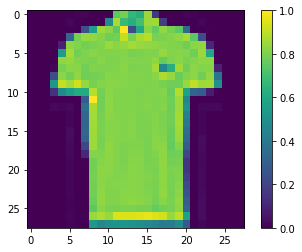

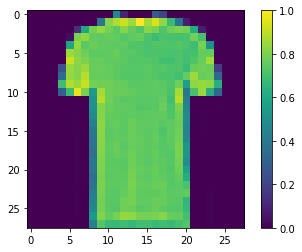

1.0


In [6]:
#Array index 
example_pair = 10

#show images at this index
show_image(test_pairs[example_pair][0])
show_image(test_pairs[example_pair][1])

#print the Label for this pair 
print(test_y[example_pair])

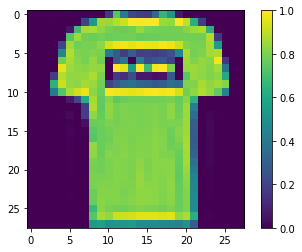

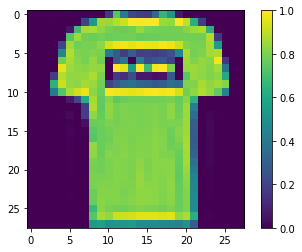

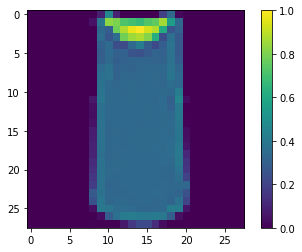

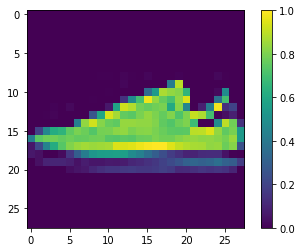

In [8]:
# print other pairs

show_image(train_pairs[:,0][0])
show_image(train_pairs[:,0][1])

show_image(train_pairs[:,1][0])
show_image(train_pairs[:,1][1])

##Build the model 

Define some utilities for building the model 

In [13]:
def initialize_base_network():
  input = Input(shape=(28,28,), name='base_input')
  x = Flatten(name='flatten_input')(input)
  x = Dense(128, activation='relu', name='first_base_dense')(x)
  x = Dropout(0.1, name='first_dropout')(x)
  x = Dense(128, activation='relu', name='second_base_dense')(x)
  x = Dropout(0.1, name='second_dropout')(x)
  x = Dense(128, activation='relu', name='third_base_dense')(x)

  return Model(inputs=input, outputs=x)

def euclidean_distance(vects):
  x, y = vects
  sum_square = K.sum(K.square(x - y), axis = 1, keepdims = True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

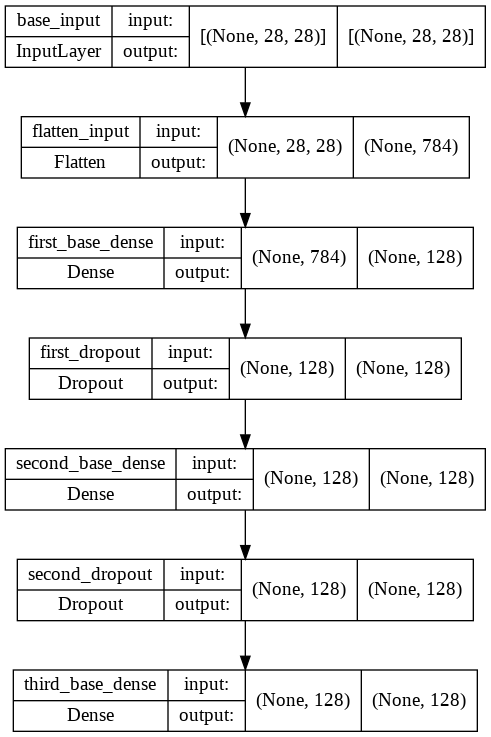

In [14]:
base_network = initialize_base_network()

plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

##Building the Siamese Network

The plot will show the inputs going into the base network 

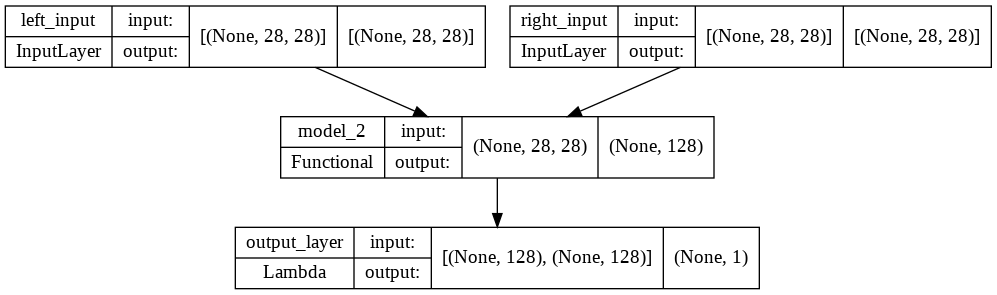

In [16]:
#Create the Left input and point to the base network 
input_a = Input(shape=(28, 28,), name='left_input')
vect_output_a = base_network(input_a)

#create the Right input and point to base network
input_b = Input(shape=(28,28,), name='right_input')
vect_output_b = base_network(input_b)

#measure the similarity of the two vector outputs 
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

#Specify the inputs and output of the model 
model = Model([input_a, input_b], output)

#plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

##Train the Model 

Define the custom loss function and start training

In [17]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
  return contrastive_loss

In [20]:
rms = RMSprop()

model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)

history = model.fit([train_pairs[:,0], train_pairs[:,1]], train_y, epochs=20, batch_size=128, validation_data=([test_pairs[:,0], test_pairs[:,1]], test_y))

Epoch 1/20
938/938 [==============================] - 11s 11ms/step - loss: 0.0558 - val_loss: 0.0632
Epoch 2/20
938/938 [==============================] - 11s 12ms/step - loss: 0.0549 - val_loss: 0.0643
Epoch 3/20
938/938 [==============================] - 11s 12ms/step - loss: 0.0540 - val_loss: 0.0637
Epoch 4/20
938/938 [==============================] - 11s 12ms/step - loss: 0.0532 - val_loss: 0.0611
Epoch 5/20
938/938 [==============================] - 11s 12ms/step - loss: 0.0528 - val_loss: 0.0626
Epoch 6/20
938/938 [==============================] - 11s 12ms/step - loss: 0.0523 - val_loss: 0.0620
Epoch 7/20
938/938 [==============================] - 10s 10ms/step - loss: 0.0517 - val_loss: 0.0626
Epoch 8/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0512 - val_loss: 0.0616
Epoch 9/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0510 - val_loss: 0.0652
Epoch 10/20
938/938 [==============================] - 10s 10ms/step - loss: 0.0507 

##Model Evaluation

Compute the accuracy and observe the metrics during training 

In [21]:
def compute_accuracy(y_true, y_pred):
  """
  Compute classification accuracy with threshold on distance 
  """

  pred = y_pred.ravel() < 0.5
  return np.mean(pred == y_true)

In [22]:
loss = model.evaluate(x=[test_pairs[:,0], test_pairs[:,1]], y=test_y)

y_pred_train = model.predict([train_pairs[:,0], train_pairs[:,1]])
train_accuracy = compute_accuracy(train_y, y_pred_train)

y_pred_test = model.predict([test_pairs[:,0], test_pairs[:,1]])
test_accuracy = compute_accuracy(test_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))


625/625 [==============================] - 1s 2ms/step - loss: 0.0607
Loss = 0.06068504974246025, Train Accuracy = 0.9466744457409568 Test Accuracy = 0.9177177177177177


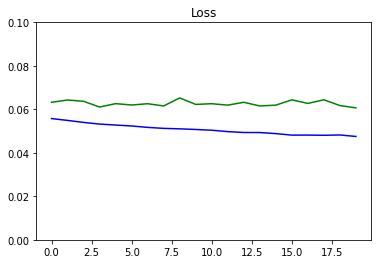

In [25]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.1)